2017- 15Sept-17Sept  
2018- 14Sept-16Sept  
2019- 20Sept-22Sept  
2022- 30Sept-02Oct  
2023- 15Sept-17Sept  
(collect data for 2023) (wait till Jan 2 coz last weekend data for 2023 is not recorded yet)

Sat-Sun (6-10PM)

In [1]:
import pandas as pd

In [2]:
def get_weektable_from_excel(date:str, demand:str):
    """
    NOTE: WORKS FOR TABLES FROM 29 SEP 2014 ONWARDS ONLY

    date = DD/MM/YYYY format -- first date of the week, by which the file is stored on ema.gov.sg

    demand = ['system', 'nem_actual', 'nem_forecast']
    """
    import pandas as pd
    import time as tm

    # base_url + year/ + ['20141222','29_Sep_2014'] + .xls
    base_url = "https://www.ema.gov.sg/content/dam/corporate/resources/statistics/half-hourly-data/"
    date_tm = tm.strptime(date,"%d/%m/%Y")

    try:
        tempdf = pd.read_excel(base_url + tm.strftime("%Y/%Y%m%d.xls",date_tm), index_col=0, header=[1,4]).iloc[:48]
    except:
        try:
            tempdf = pd.read_excel(base_url + tm.strftime("%Y/%d_%b_%Y.xls",date_tm), index_col=0, header=[1,4]).iloc[:48]
        except:
            # 02 Jan 2017 error
            tempdf = pd.read_excel('https://www.ema.gov.sg/content/dam/corporate/resources/statistics/half-hourly-data/2016/20170102.xls', index_col=0, header=[1,4]).iloc[:48]
    
    demand_in = ['system','nem_actual','nem_forecast']
    demand_out = [' System Demand (Actual)',' NEM Demand (Actual)',' NEM Demand (Forecast)']
    if demand == demand_in[0]:
        try:
            return tempdf.xs(demand_out[0], axis=1, level=1)
        except:
            print('No system demand column!')
    elif demand == demand_in[1]:
        try:
            return tempdf.xs(demand_out[1], axis=1, level=1)
        except:
            return tempdf.xs('NEM Demand ', axis=1, level=1)
    elif demand == demand_in[2]:
        try:
            return tempdf.xs(demand_out[2], axis=1, level=1)
        except:
            return tempdf.xs('VSTLF', axis=1, level=1)

def yearly_excel(startdate:str, enddate:str, demand:str):
    import pandas as pd
    import time as tm
    import datetime as dt

    startdate_tm = tm.strptime(startdate,"%d/%m/%Y")
    enddate_tm = tm.strptime(enddate,"%d/%m/%Y")
    delta = dt.timedelta(days = 7)

    currdate_tm = startdate_tm
    tempdf = get_weektable_from_excel(date=tm.strftime('%d/%m/%Y',currdate_tm), demand=demand)

    #updating
    prev_df = tempdf
    prev_date = currdate_tm
    currdate_tm = dt.datetime(currdate_tm[0],currdate_tm[1],currdate_tm[2])
    currdate_tm += delta
    currdate_tm = currdate_tm.timetuple()

    while (currdate_tm <= enddate_tm):
        tempdf = get_weektable_from_excel(date=tm.strftime('%d/%m/%Y',currdate_tm), demand=demand)

        #adding to dataframes according to years
        if (currdate_tm.tm_year == prev_date.tm_year):
            prev_df = pd.concat([prev_df,tempdf], axis=1)
        else:
            #save prev_df in excel with prev year name
            prev_df.columns = prev_df.columns.strftime("%d/%m/%Y")
            prev_df.to_excel(str(prev_date.tm_year) + f'[{demand}]' + ".xlsx")
            prev_df = tempdf

        #updating
        prev_date = currdate_tm
        currdate_tm = dt.datetime(currdate_tm[0],currdate_tm[1],currdate_tm[2])
        currdate_tm += delta
        currdate_tm = currdate_tm.timetuple()

Data Collection

In [3]:
def weekendfone(year):
    df = pd.read_excel(f'Yearly Energy Demand Data/System Demand (Actual)/{year}.xlsx', index_col=0)
    df.columns = pd.to_datetime(df.columns, dayfirst=True)
    saturdays = {}
    sundays  = {}
    for i in df.columns:
        if i.weekday() == 5:
            saturdays[i] = sum(df[i]['18:30':'22:00'])
        elif i.weekday() == 6:
            sundays[i] = sum(df[i]['18:30':'22:00'])
        
    saturdays = pd.Series(saturdays)
    sundays = pd.Series(sundays)

    i_sm = {1: 0.9579037796074662,
        2: 0.9596186164365493,
        3: 0.9898073559402792,
        4: 1.0030397134620446,
        5: 1.018392643199991,
        6: 1.0261222064430728,
        7: 1.02305328000198,
        8: 1.017260959899729,
        9: 1.020519376655325,
        10: 1.011875522378184,
        11: 0.9942104067376999,
        12: 0.976059327973805}

    weekends = {}

    for i in range(len(saturdays)):
        weekends[saturdays.index[i].strftime("%d%b") +'-'+ sundays.index[i].strftime("%d%b")] = saturdays[i] + sundays[i]

    weekends = pd.Series(weekends)
    deseasonalized = weekends.copy()
    
    for i in range(len(saturdays)):
        deseasonalized.iloc[i] = deseasonalized.iloc[i] / i_sm[saturdays.index[i].month]

    #deseasonalized.plot(xticks=range(len(deseasonalized)), rot=90, figsize=(20,10), grid=True, title=f'Deseasonalized Weekend 18:00-22:00 Energy Demand for {year}')
    deseasonalized.to_excel(f'{year} Weekendfone.xlsx')

for year in [2017,2018,2019,2022]:
    weekendfone(year)

In [4]:
weekendfone(2021)

Data Viz

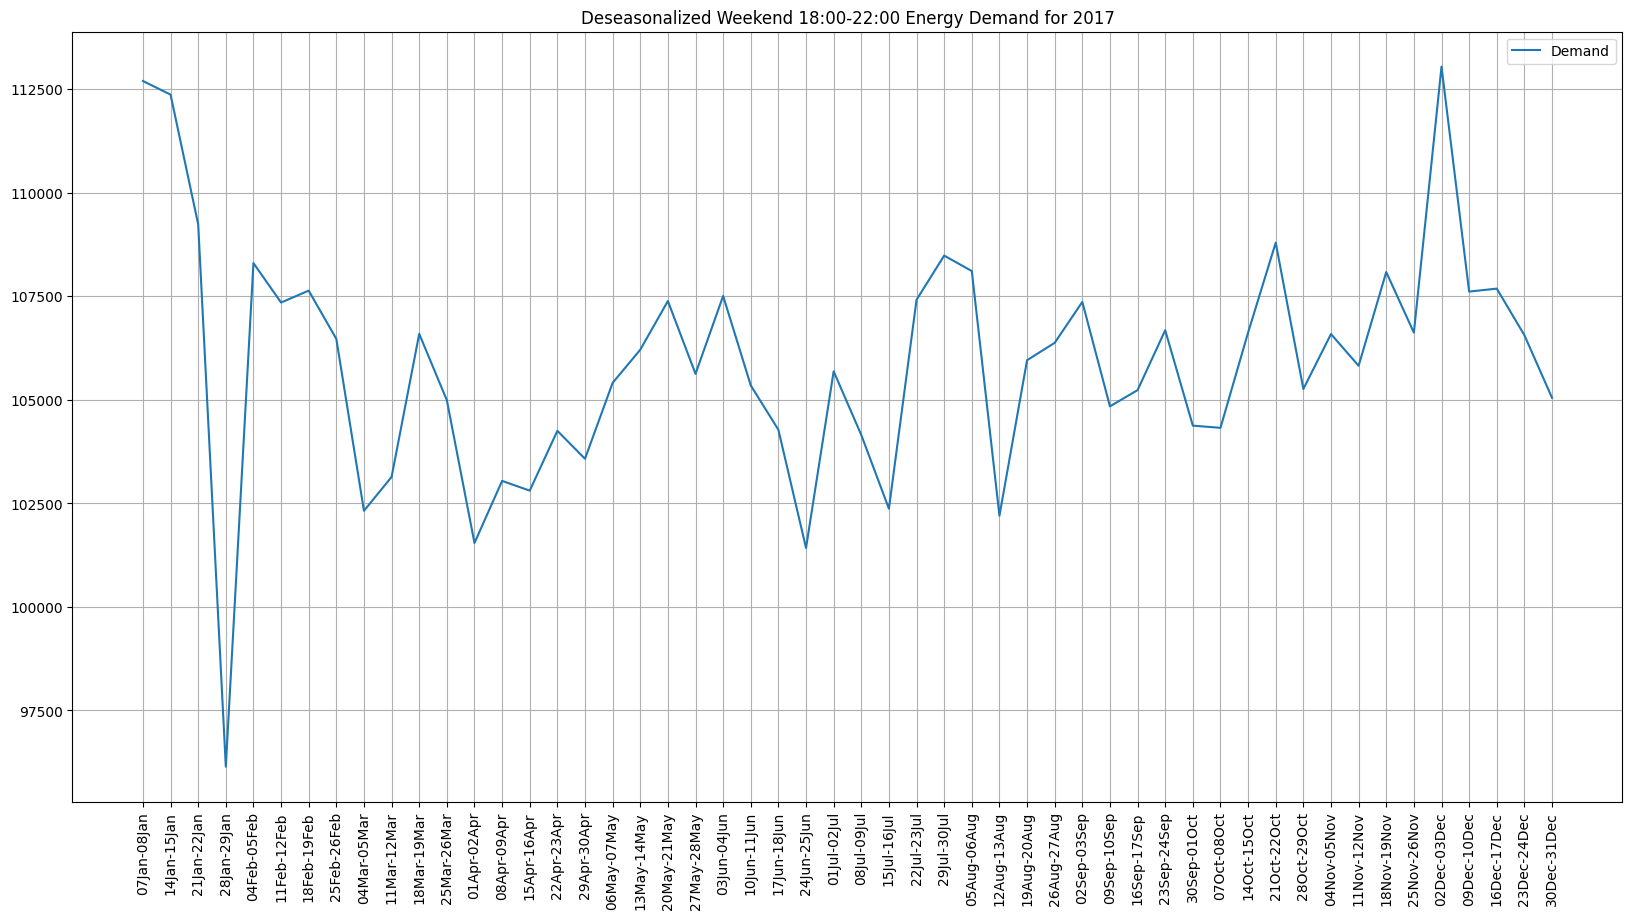

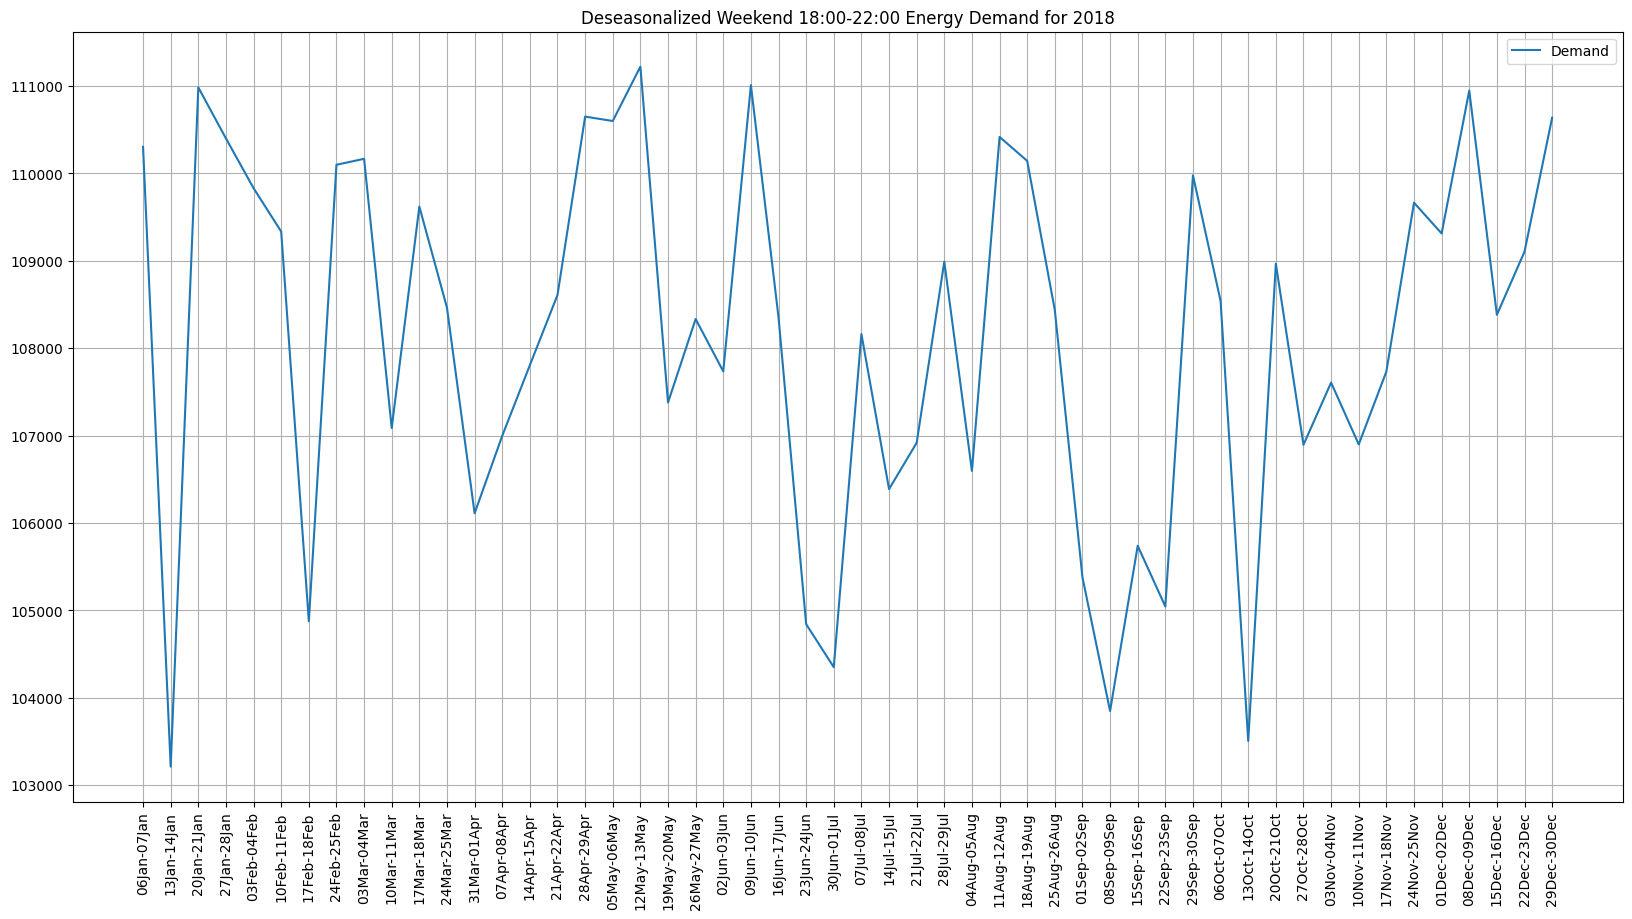

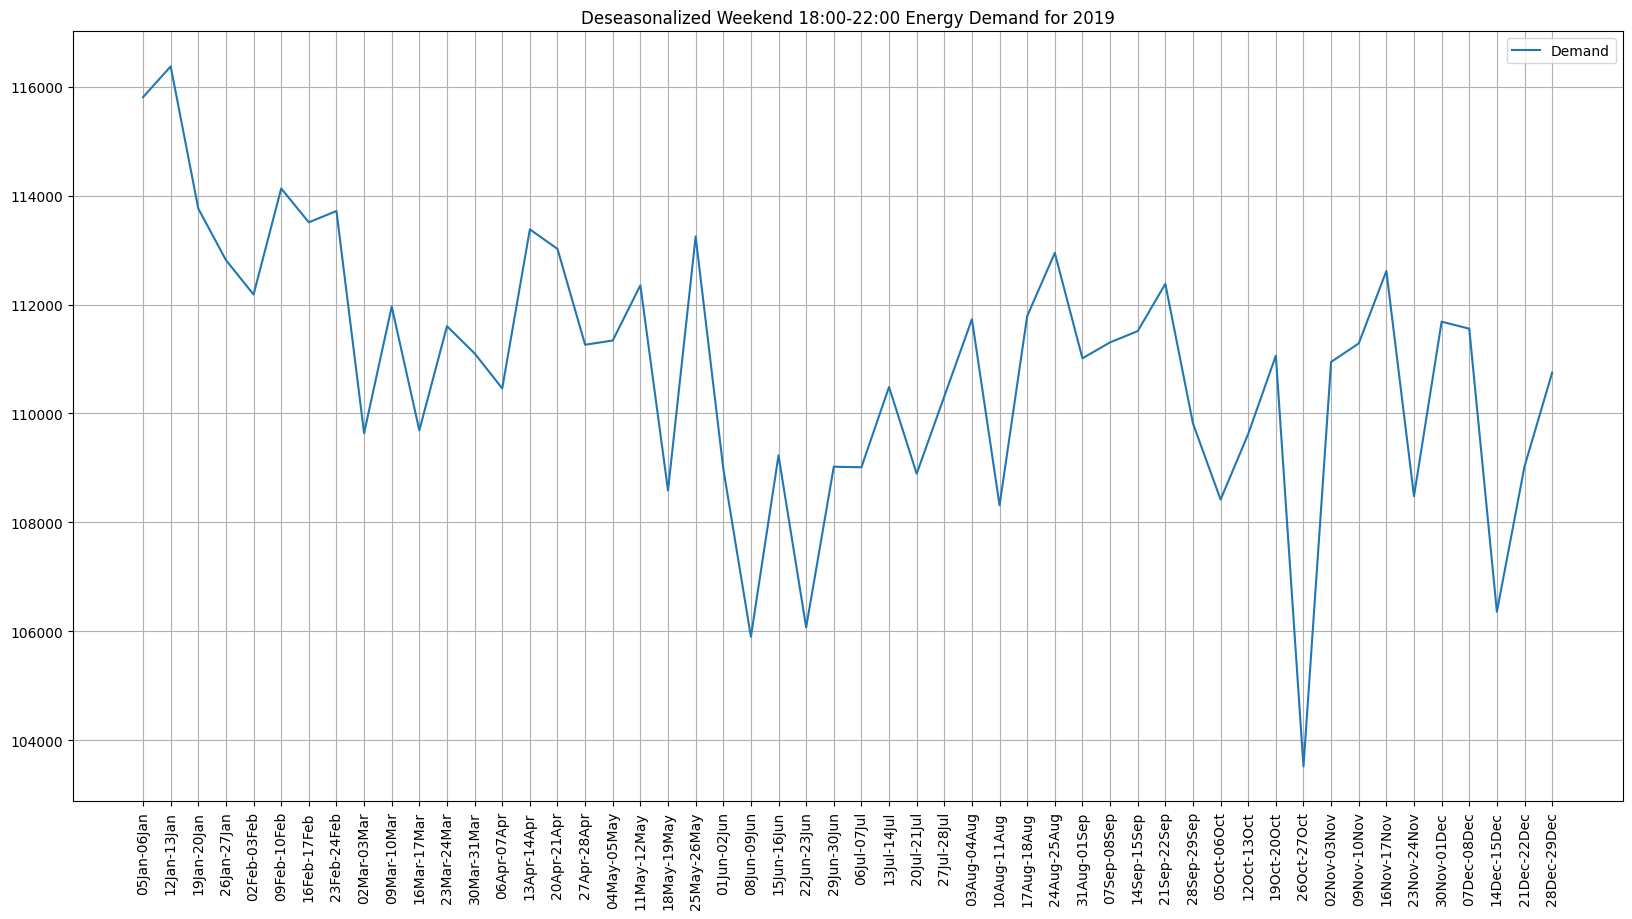

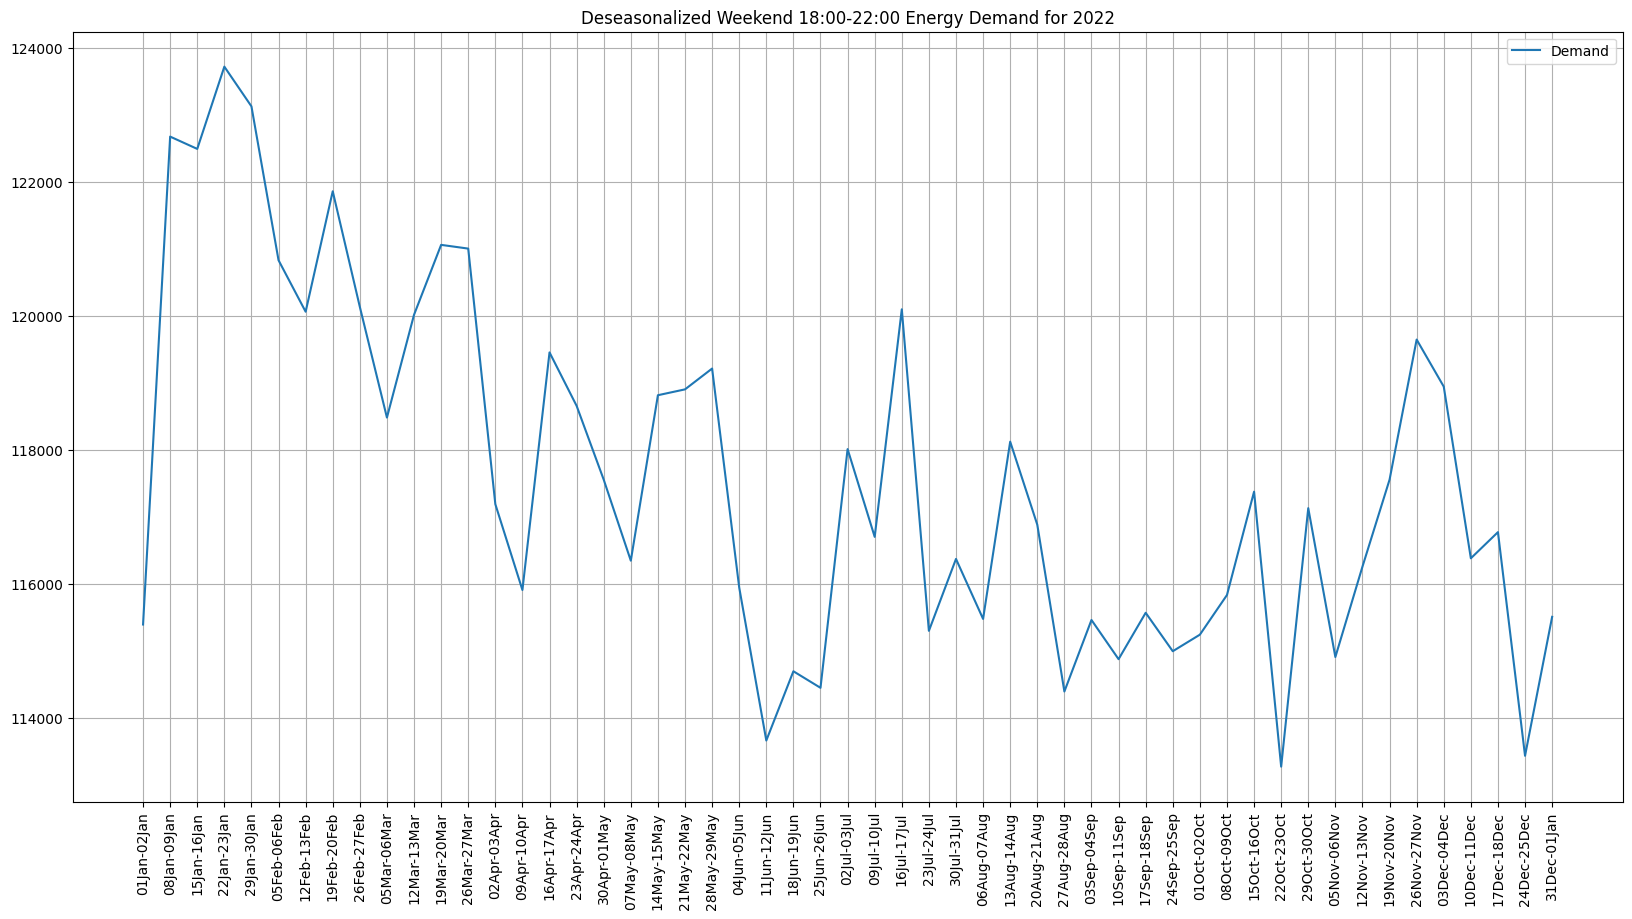

In [5]:
for year in [2017,2018,2019,2022]:
    df = pd.read_excel('DeseasonalizedWeekendsF1.xlsx', index_col=0, sheet_name=str(year))
    df.plot(xticks=range(len(df)), rot=90, figsize=(20,10), grid=True, title=f'Deseasonalized Weekend 18:00-22:00 Energy Demand for {year}')